In [33]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl 
import cartopy.crs as ccrs
import cftime
import matplotlib.lines as mlines

# import pyClimat models 
from pyClimat.plot_utils import *
from pyClimat.plots import plot_annual_mean
from pyClimat.plots import plot_seasonal_mean
from pyClimat.data import read_from_path
from pyClimat.analysis import compute_lterm_mean
from pyClimat.utils import extract_indices_around

Calculating the seasonal mean without considering the number of days in a month
Calculating the seasonal mean without considering the number of days in a month
Calculating the seasonal mean without considering the number of days in a month


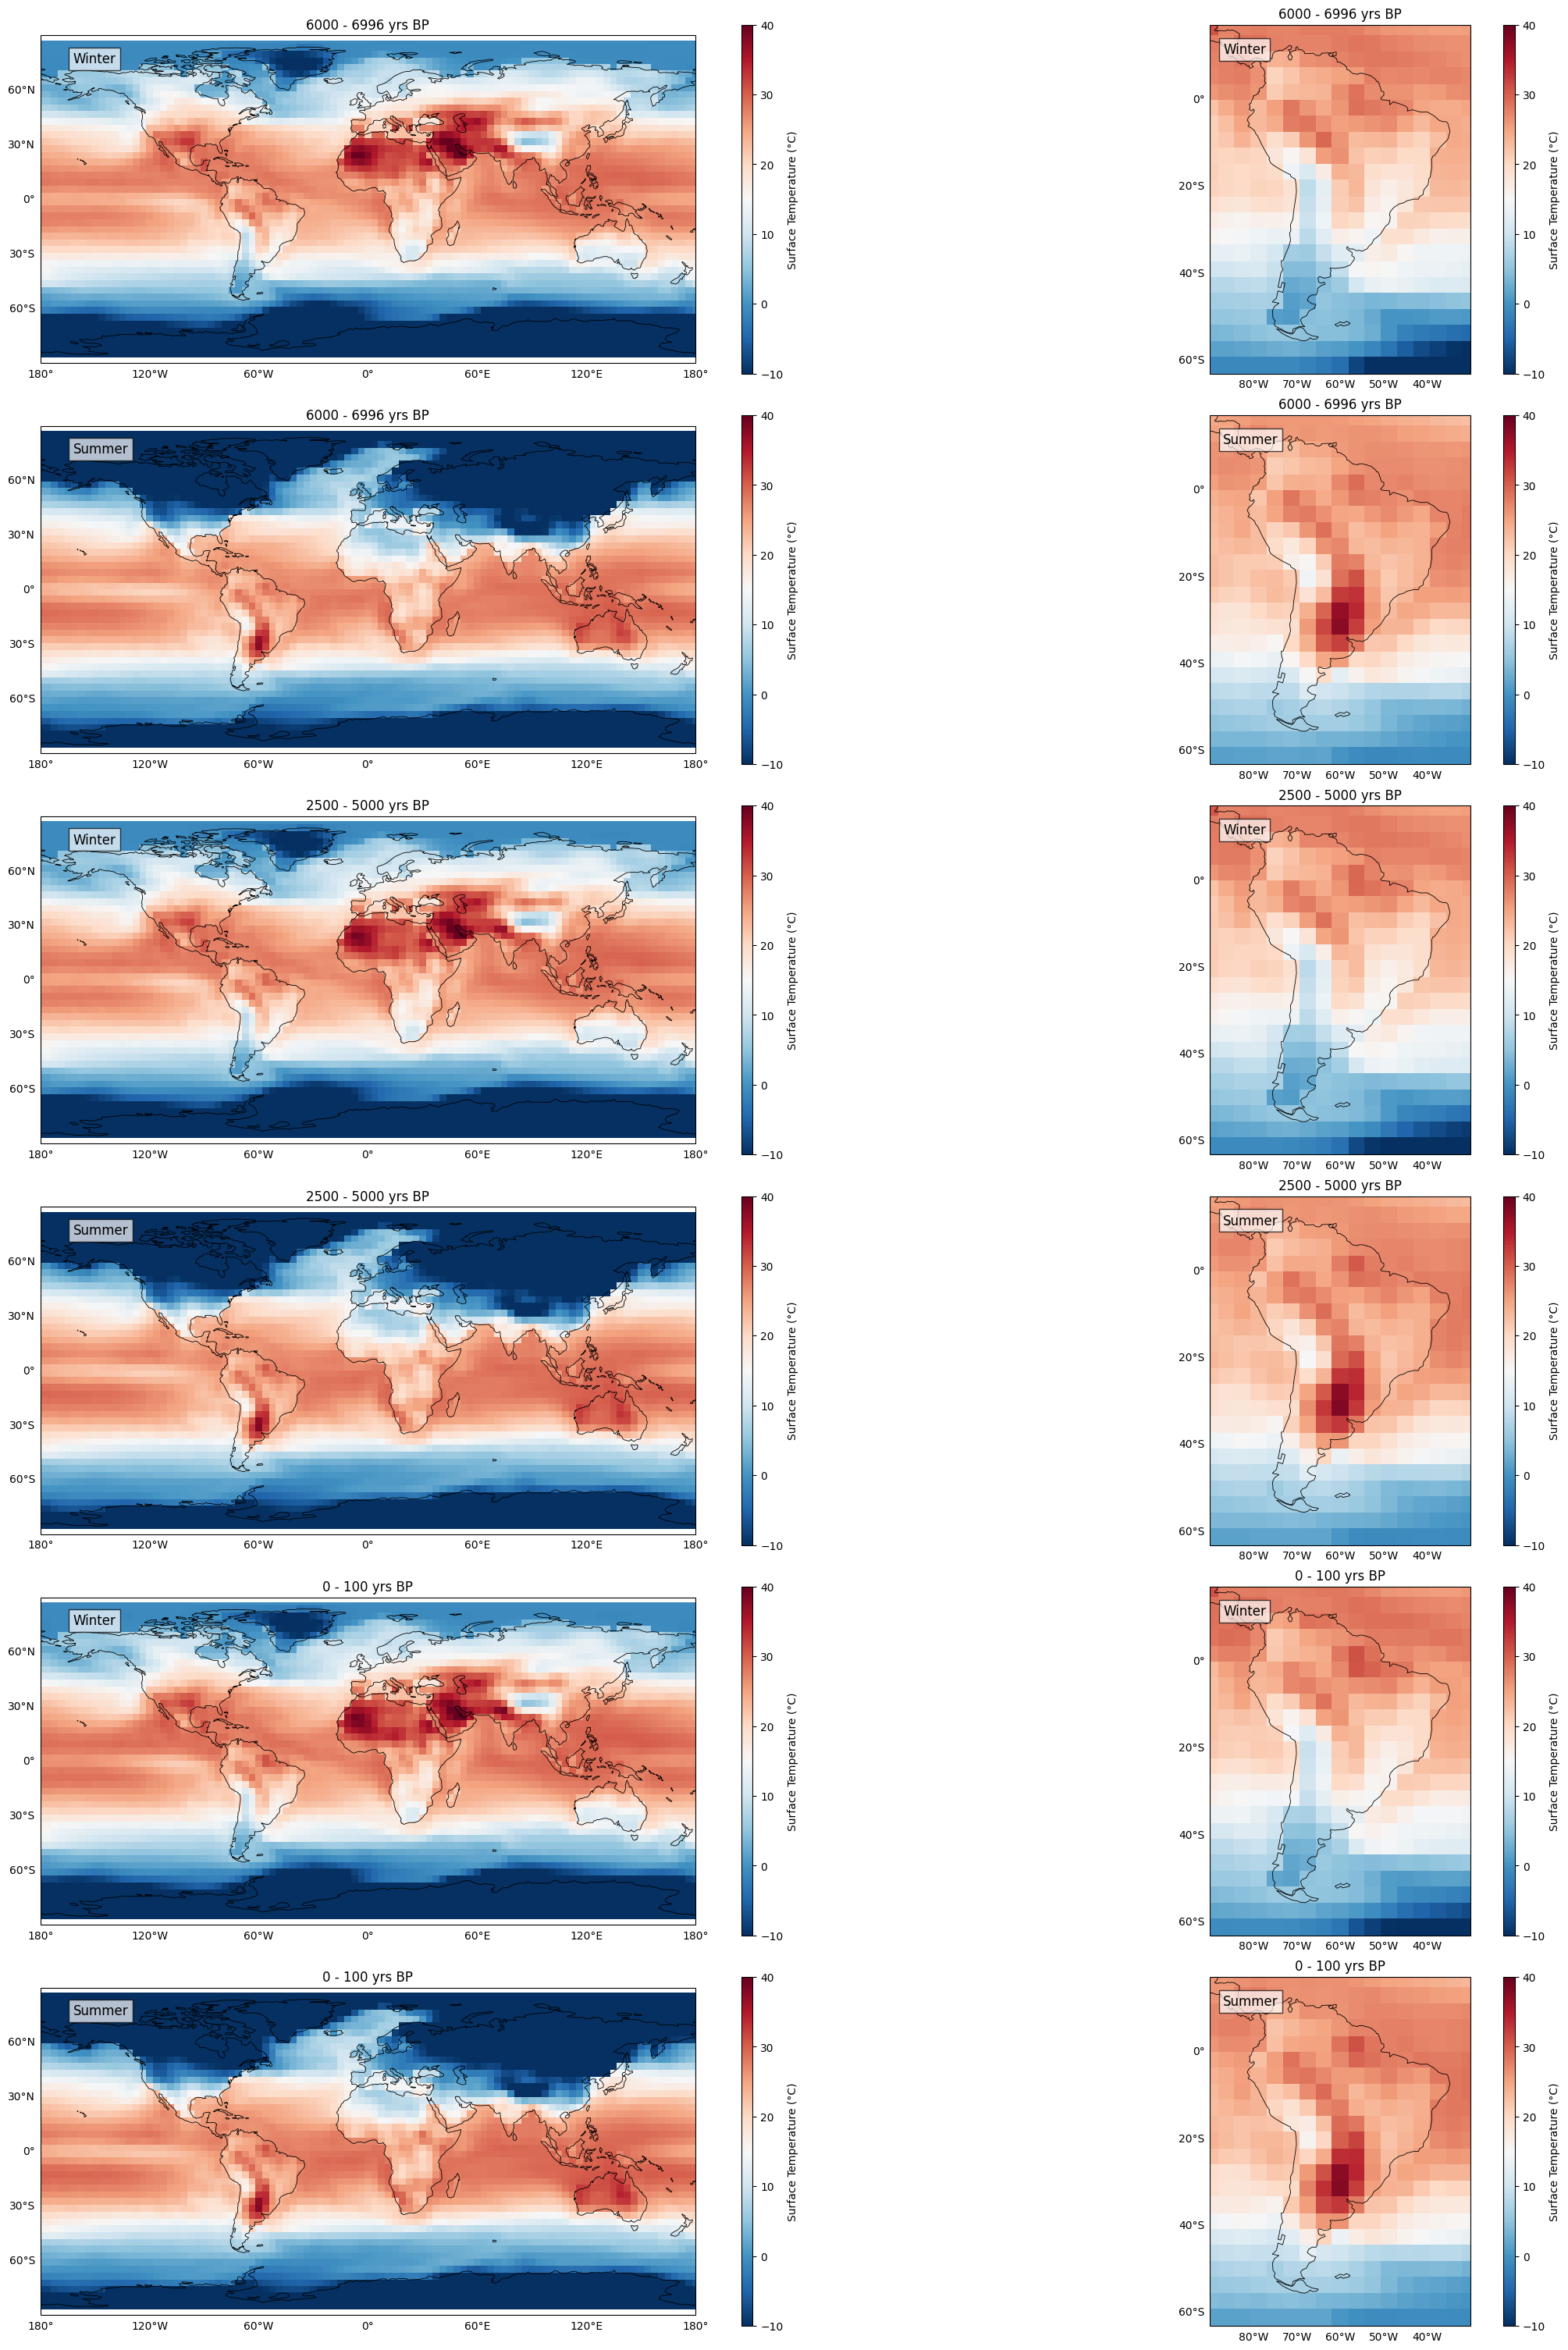

In [34]:
#---------------------------global & south america SEASONAL TEMPERATURE (different time ranges)------------------

# Reading the data
path            = "/home/rvejayan/ECHAM-wiso_7k_data/ECHAM5-wiso_7k"
filename_mon    = "Hol-T_echam5_wiso_tsurf_0004_to_7000.nc"
data            = read_from_path(path=path, filename=filename_mon, varname= "tsurf", decode=True)

# Determine the length of time dimension in data
time_length     = data.sizes['time']

# Index where the gap starts
split_index     = 66557 

# Split the precipitation data into two parts
data_first_part  = data.isel(time=slice(None, split_index))
data_second_part = data.isel(time=slice(split_index, None))

# Generate the first part of the time range
first_start_date = "0000-01-01"
first_end_date   = "5546-05-01"
first_dates      = xr.cftime_range(start=first_start_date, end=first_end_date, freq='MS', calendar="noleap")

# Generate the second part of the time range
second_start_date = "5547-01-01"
second_periods    = data_second_part.sizes['time']
second_dates      = xr.cftime_range(start=second_start_date, periods=second_periods, freq='MS', calendar="noleap")

# Assign the new time coordinates to each part
data_first_part  = data_first_part.assign_coords(time=first_dates)
data_second_part = data_second_part.assign_coords(time=second_dates)

# Concatenate both parts to form the complete time range
complete_dates = first_dates.append(second_dates)

# Concatenate the two parts
complete_data = xr.concat([data_first_part, data_second_part], dim='time')

# Replace the 'time' coordinate in your 'data' object with the new dates
complete_data["time"] = complete_dates

"""

cftime.range does not have the function .sel() to select the precip data for specific dates. Instead indexing the dates variable would give 
the specific date range since dates variable has been assigned to time variable in data.

start_index    - The desired starting year multiplied by 12 to convert years to months + the extra months and then minus 1 because Python 
                 indexes start from 0.

end_index      - Same as for start_index but it's for desired end year.

data_range     - Setting the range of time data needed

selected_data  - Now the precip data from the data file can be selected between the desired time period using .sel()

"""

# Define start and end index ranges
start_indices = [0, (1996 * 12) + 1 -1, (6896 * 12) + 1 - 1]
end_indices   = [(996 * 12) + 12 - 1, (4496 * 12) + 12 - 1, (6996 * 12) + 5 - 1]

# Define titles for each range
titles = ["6000 - 6996 yrs BP", "2500 - 5000 yrs BP", "0 - 100 yrs BP"] # not minus but start time to end time 

# Initialize lists to store seasonal means
seasonal_mean_winter_list = []
seasonal_mean_summer_list = []

# Create figure with subplots
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 20), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
#fig.tight_layout(h_pad=7.0, w_pad=0.5)

# Iterate over index ranges and titles
for i, (start_index, end_index, title) in enumerate(zip(start_indices, end_indices, titles)):
    # Slice data for the current range
    selected_data        = complete_data.isel(time=slice(start_index, end_index + 1))
    # Compute seasonal mean
    seasonal_mean        = compute_lterm_mean(data=selected_data, time="season")
    # Select winter and summer seasons
    seasonal_mean_winter = seasonal_mean.sel(season="JJA")
    seasonal_mean_summer = seasonal_mean.sel(season="DJF")
    # Append to lists
    seasonal_mean_winter_list.append(seasonal_mean_winter)
    seasonal_mean_summer_list.append(seasonal_mean_summer)

    # Plot winter global
    ax = axes[i * 2, 0]
    im = seasonal_mean_winter.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                                     vmin=-10, vmax=40)
    ax.coastlines(linewidth=0.6)
    gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--', linewidth=1.0)
    gl.right_labels = False
    gl.top_labels   = False
    ax.set_title(f"{title}")

    # Add annotation for winter inside the plot
    ax.text(0.05, 0.95, 'Winter', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

    # Add colorbar with label
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', aspect=30)
    cbar.set_label('Surface Temperature (°C)')  

    # Plot summer global
    ax = axes[i * 2 + 1, 0]
    im = seasonal_mean_summer.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                                     vmin=-10, vmax=40)
    ax.coastlines(linewidth=0.6)
    gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--', linewidth=1.0)
    gl.right_labels = False
    gl.top_labels   = False
    ax.set_title(f"{title}")

    # Add annotation for summer inside the plot
    ax.text(0.05, 0.95, 'Summer', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

    # Add colorbar with label
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', aspect=30)
    cbar.set_label('Surface Temperature (°C)')  

    # Plot winter South America
    ax = axes[i * 2, 1]
    fig.set_size_inches(10, 30, forward=True)  # Adjust the figure size for South America plots
    im = seasonal_mean_winter.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                                     vmin=-10, vmax=40)
    fig.set_size_inches(10, 20, forward=True)  # Reset figure size to original after plotting

    ax.coastlines(linewidth=0.6)
    ax.set_extent([-90, -30, -60, 15])  # Set the extent to focus on South America
    gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--', linewidth=1.0)
    gl.right_labels = False
    gl.top_labels   = False
    ax.set_title(f"{title}")

    # Add annotation for winter inside the plot
    ax.text(0.05, 0.95, 'Winter', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

    # Add colorbar with label
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', aspect=30)
    cbar.set_label('Surface Temperature (°C)')  

    # Plot summer South America
    ax = axes[i * 2 + 1, 1]
    fig.set_size_inches(20, 40, forward=True)  # Adjust the figure size for South America plots
    im = seasonal_mean_summer.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                                     vmin=-10, vmax=40)
    fig.set_size_inches(20, 30, forward=True)  # Reset figure size to original after plotting

    ax.coastlines(linewidth=0.6)
    ax.set_extent([-90, -30, -60, 15])  # Set the extent to focus on South America
    gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--', linewidth=1.0)
    gl.right_labels = False
    gl.top_labels   = False
    ax.set_title(f"{title}")

    # Add annotation for summer inside the plot
    ax.text(0.05, 0.95, 'Summer', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

    # Add colorbar with label
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', aspect=30)
    cbar.set_label('Surface Temperature (°C)')  
    
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/all_seasonal_TEMP.png", bbox_inches='tight')

Calculating the seasonal mean without considering the number of days in a month


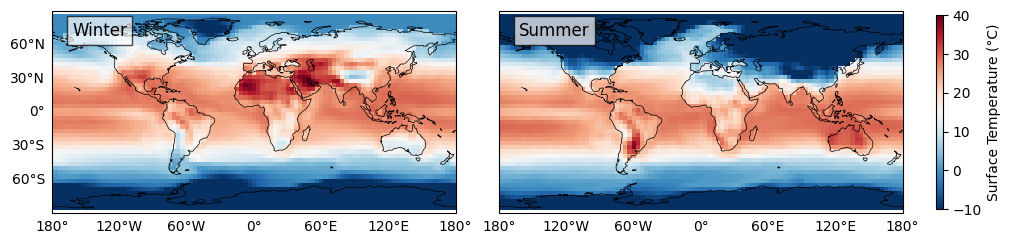

In [37]:
#-----------------------global only SEASONAL TEMPERATURE (0 to 6996 years BP)---------------------------

# Define the start and end indices for 0-6996 years BP
start_index = 0
end_index   = (6996 * 12) + 1 - 1  # Adjust based on the desired end point

# Slice the data for the 0-6996 years BP range
selected_data = complete_data.isel(time=slice(start_index, end_index + 1))

# Compute seasonal mean
seasonal_mean = compute_lterm_mean(data=selected_data, time="season")

# Select winter and summer seasons
seasonal_mean_summer = seasonal_mean.sel(season="DJF")
seasonal_mean_winter = seasonal_mean.sel(season="JJA")

# Create figure with subplots for winter and summer
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 13), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

# Plot summer global
ax = axes[1]
im = seasonal_mean_summer.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                                      vmin=-10, vmax=40)
ax.coastlines(linewidth=0.5)
gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels = False
gl.left_labels  = False
gl.top_labels   = False

# Remove the automatic title
ax.set_title('')

# Add annotation for summer inside the plot
ax.text(0.05, 0.95, 'Summer', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Plot winter global
ax = axes[0]
im = seasonal_mean_winter.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                                      vmin=-10, vmax=40)
ax.coastlines(linewidth=0.5)
gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--', linewidth=0.3)
gl.right_labels = False
gl.top_labels   = False

# Remove the automatic title
ax.set_title('')

# Add annotation for winter inside the plot
ax.text(0.05, 0.95, 'Winter', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Add colorbar with shrink below the summer plot
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.15, aspect=30, pad=0.02)
cbar.set_label('Surface Temperature (°C)')

# Save the combined figure without any external titles
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/0-6996_global_seasonal_TEMP.png", bbox_inches='tight')

Calculating the seasonal mean without considering the number of days in a month


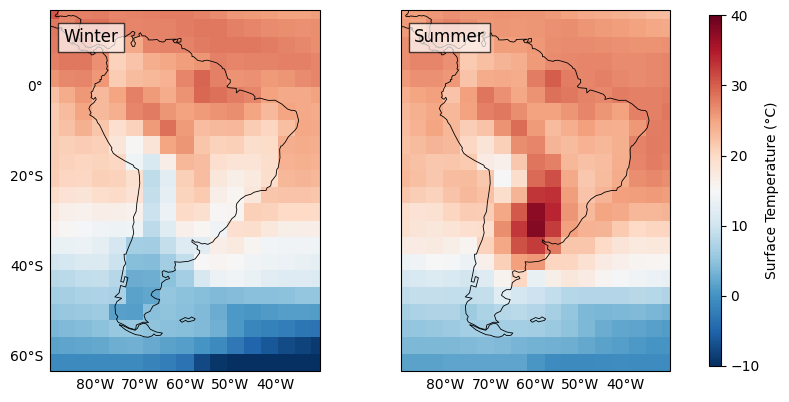

In [38]:
#------------------south america only SEASONAL TEMPERATURE (0 to 6996 years BP)-----------------------------

# Define the start and end indices for 0-6996 years BP
start_index = 0
end_index   = (6996 * 12) + 1 - 1 

# Slice the data for the 0-6996 years BP range
selected_data = complete_data.isel(time=slice(start_index, end_index + 1))

# Compute seasonal mean
seasonal_mean = compute_lterm_mean(data=selected_data, time="season")

# Select winter and summer seasons
seasonal_mean_summer = seasonal_mean.sel(season="DJF")
seasonal_mean_winter = seasonal_mean.sel(season="JJA")

# Create figure with subplots for winter and summer
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 13), subplot_kw={'projection': ccrs.PlateCarree()})#, constrained_layout=True)

# Adjust space between plots
fig.subplots_adjust(wspace=0.3)  # Increase the value to add more space between plots

# Plot summer global
ax = axes[1]
im = seasonal_mean_summer.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                                      vmin=-10, vmax=40)
ax.coastlines(linewidth=0.6)
ax.set_extent([-90, -30, -60, 15])  # Set the extent to focus on South America
gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels = False
gl.left_labels = False
gl.top_labels   = False

# Remove the automatic title
ax.set_title('')

# Add annotation for summer inside the plot
ax.text(0.05, 0.95, 'Summer', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Plot winter global
ax = axes[0]
im = seasonal_mean_winter.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                                      vmin=-10, vmax=40)
ax.coastlines(linewidth=0.6)
ax.set_extent([-90, -30, -60, 15])  # Set the extent to focus on South America
gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels = False
gl.top_labels   = False

# Remove the automatic title
ax.set_title('')

# Add annotation for winter inside the plot
ax.text(0.05, 0.95, 'Winter', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Add colorbar with shrink below the summer plot
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.35, aspect=30, pad=0.05)
cbar.set_label('Surface Temperature (°C)')

# Save the combined figure without any external titles
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/0-6996_SA_seasonal_TEMP.png", bbox_inches='tight')

Define the time period for long-term mean or the annual mean is computed
Define the time period for long-term mean or the annual mean is computed
Define the time period for long-term mean or the annual mean is computed


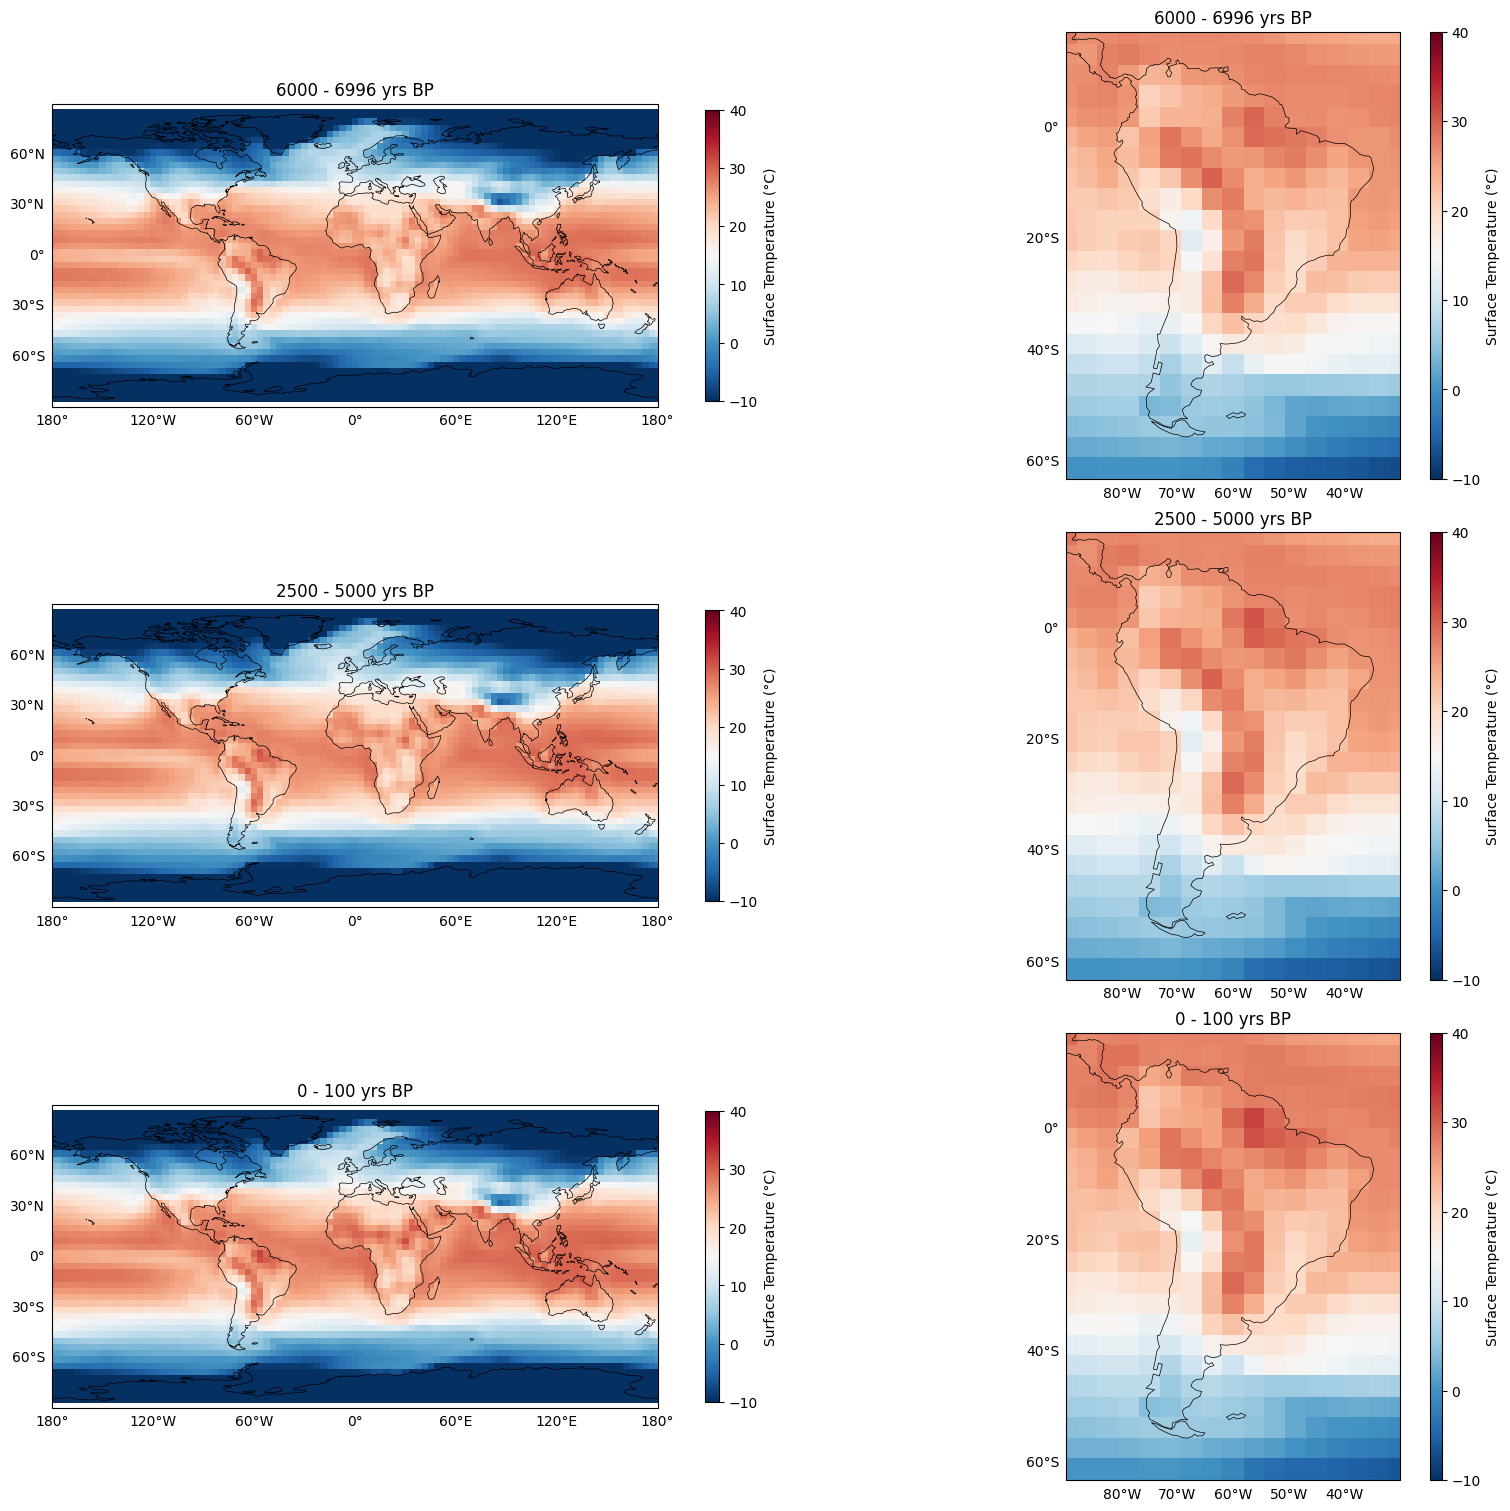

In [39]:
#------------------------global & south america ANNUAL TEMPERATURE (different time ranges)--------------------------

# reading data
filename_ann    = "Hol-T_echam5_wiso_tsurf_0004_to_7000_yearmean.nc"
data_ann        = read_from_path(path=path, filename=filename_ann, varname= "tsurf", decode=True)

# getting time range for annual precip
dates_ann           = xr.cftime_range(start="0000", periods=6997, freq='YS', calendar="noleap")
data_ann["time"]    = dates_ann

# Define start and end index ranges
start_index_ann = [0, 1996, 6896]
end_index_ann   = [996, 4496, 6996]

# Define titles for each range
titles = ["6000 - 6996 yrs BP", "2500 - 5000 yrs BP", "0 - 100 yrs BP"]

# Create figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
#fig.tight_layout(pad=14.0)

# Iterate over index ranges and titles
for i, (start_index, end_index, title) in enumerate(zip(start_index_ann, end_index_ann, titles)):
    # Slice dates for the current range
    date_range_ann    = dates_ann[start_index:end_index]
    # Slice data for the current date range
    selected_data_ann = data_ann.sel(time=date_range_ann)
    # Get the final mean from all the annual mean
    annual_mean       = compute_lterm_mean(data=selected_data_ann, time='annual')

    # Plot annual Global
    ax = axes[i, 0]
    img = annual_mean.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-10, vmax=40)
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
    gl.right_labels = False
    gl.top_labels   = False
    ax.set_title(f"{title}")
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=0.65, pad=0.05) # Add colorbar for global annual plot
    cbar.set_label('Surface Temperature (°C)')  
    
    # Plot annual South America
    ax = axes[i, 1]
    fig.set_size_inches(15, 20, forward=True)  # Adjust the figure size for South America plots
    img = annual_mean.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-10, vmax=40)
    fig.set_size_inches(15, 15, forward=True)  # Reset figure size to original after plotting
    ax.coastlines(linewidth=0.5)
    ax.set_extent([-90, -30, -60, 15])  # Set the extent to focus on South America
    gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
    gl.right_labels = False
    gl.top_labels   = False
    ax.set_title(f"{title}")
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.05, aspect=40)  # Add colorbar for South America annual plot
    cbar.set_label('Surface Temperature (°C)')  
   
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/all_annual_TEMP.png", bbox_inches='tight')

Define the time period for long-term mean or the annual mean is computed


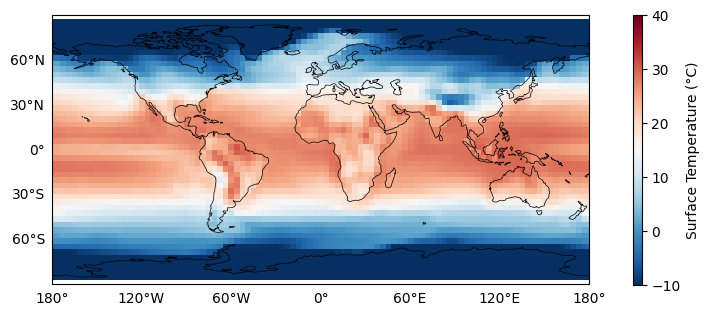

In [40]:
#-------------------------global only ANNUAL TEMPERATURE (0 to 6996 years BP)-------------------------------------

# Define start and end index ranges for 0-6996 years BP
start_index_ann = 0
end_index_ann   = 6996

# Slice dates and data for the time range 0-6996 years BP
date_range_ann    = dates_ann[start_index_ann:end_index_ann + 1]
selected_data_ann = data_ann.sel(time=date_range_ann)

# Compute the annual mean for the selected time range
annual_mean = compute_lterm_mean(data=selected_data_ann, time='annual')

# Create a figure for global annual temperature
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

# Plot global annual temperature
img = annual_mean.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-10, vmax=40)
ax.coastlines(linewidth=0.5)
gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels = False
gl.top_labels   = False
#ax.set_title("0 - 6996 yrs BP (global annual)")

# Remove the automatic title
ax.set_title('')

cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=0.55, pad=0.05, aspect=30)  # Add colorbar for global annual plot
cbar.set_label('Surface Temperature (°C)')  

plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/0-6996_global_annual_TEMP.png", bbox_inches='tight')

Define the time period for long-term mean or the annual mean is computed


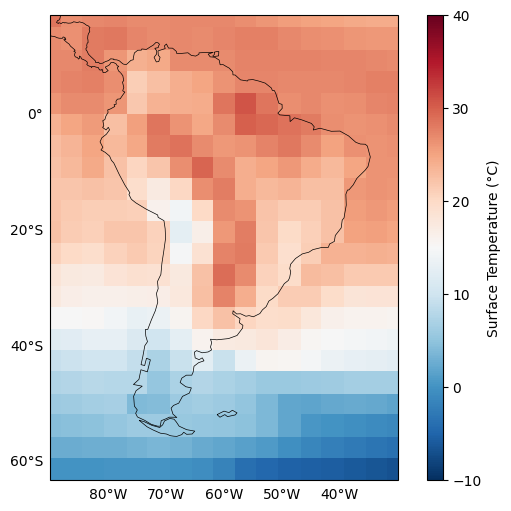

In [41]:
#-----------------------south america only ANNUAL TEMPERATURE (0 to 6996 years BP)---------------------------------

# Define start and end index ranges for 0-6996 years BP
start_index_ann = 0
end_index_ann   = 6996

# Slice dates and data for the time range 0-6996 years BP
date_range_ann    = dates_ann[start_index_ann:end_index_ann + 1]
selected_data_ann = data_ann.sel(time=date_range_ann)

# Compute the annual mean for the selected time range
annual_mean = compute_lterm_mean(data=selected_data_ann, time='annual')

# Create a figure for global annual temperature
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

# Plot global annual temperature
img = annual_mean.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-10, vmax=40)
ax.coastlines(linewidth=0.5)
ax.set_extent([-90, -30, -60, 15])  # Set the extent to focus on South America
gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels = False
gl.top_labels   = False
#ax.set_title("0 - 6996 yrs BP (global annual)")

# Remove the automatic title
ax.set_title('')

cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=1.0, pad=0.05, aspect=30)  # Add colorbar for global annual plot
cbar.set_label('Surface Temperature (°C)')  

plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/0-6996_SA_annual_TEMP.png", bbox_inches='tight')

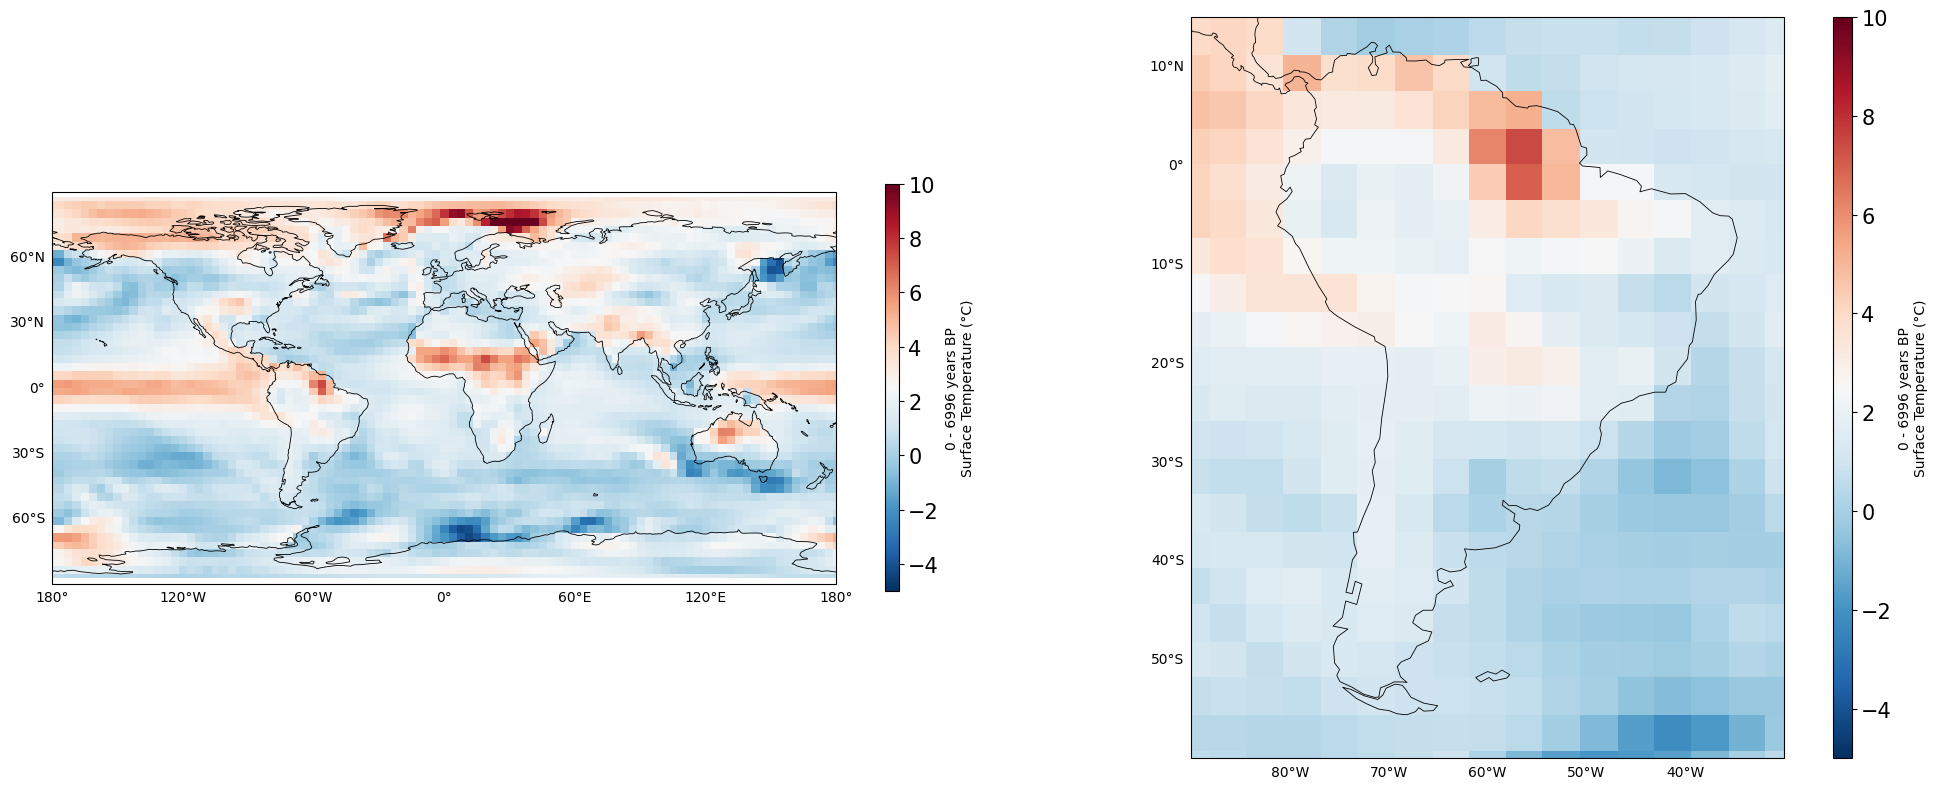

In [42]:
#---------------------global and south america annual temperature DIFFERENCE (0 minus 6996)--------------------

# Select data for 0 and 6996 yrs BP 
data_0_BP    = data_ann.sel(time=dates_ann[-1])
data_6996_BP = data_ann.sel(time=dates_ann[0])

# Getting the difference in annual temperature between 6996 yrs BP and 0 yrs BP
data_diff    = data_0_BP - data_6996_BP

# Plotting the difference in annual surface temperature for Global and South America
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
#fig.suptitle('Difference in Annual Surface Temperature (0 minus 6996 yrs BP)', fontsize=15)

# Plotting for Global
ax_global = axes[0]
img_global = data_diff.plot.imshow(ax=ax_global, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-5, vmax=10)
ax_global.coastlines(linewidth=0.6)
gl = ax_global.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels  = False
gl.top_labels = False
#ax_global.set_title('Global', fontsize=15)
ax_global.set_global()

# Adjusting tick label sizes for global plot
ax_global.tick_params(axis='both', which='major', labelsize=17)

# Plotting for South America
ax_sa = axes[1]
img_sa = data_diff.plot.imshow(ax=ax_sa, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-5, vmax=10)
ax_sa.coastlines(linewidth=0.6)
gl = ax_sa.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels  = False
gl.top_labels = False
#ax_sa.set_title('South America', fontsize=15)
ax_sa.set_extent([-90, -30, -60, 15], crs=ccrs.PlateCarree())  # Set South America extent

# Adjusting tick label sizes for South America plot
ax_sa.tick_params(axis='both', which='major', labelsize=17)

# Colorbars
cbar_global = fig.colorbar(img_global, ax=ax_global, orientation='vertical',  shrink=0.55, pad=0.05, aspect=30)
cbar_global.set_label('0 - 6996 years BP' + '\n' + 'Surface Temperature (°C)')
cbar_global.ax.tick_params(labelsize=15)  # Adjust colorbar tick label size

cbar_sa = fig.colorbar(img_sa, ax=ax_sa, orientation='vertical', shrink=1.0, pad=0.05, aspect=40)
cbar_sa.set_label('0 - 6996 years BP' + '\n' + 'Surface Temperature (°C)')
cbar_sa.ax.tick_params(labelsize=15)  # Adjust colorbar tick label size
plt.tight_layout()
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/all_diff_annual_TEMP.png")

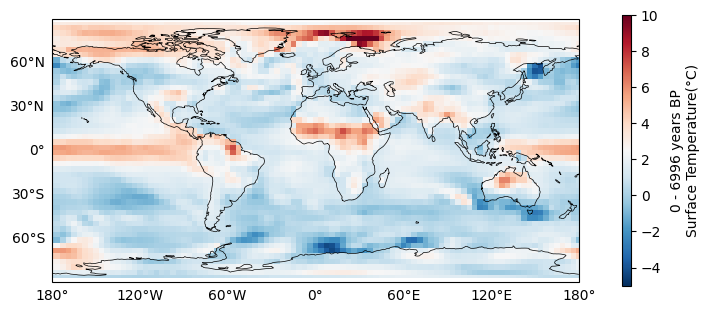

In [43]:
#------------------------------global only annual temperature DIFFERENCE (0 minus 6996)----------------------------

# Create a figure for the global difference in temperature
fig, ax_global = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)
#fig.suptitle('Difference in Annual Surface Temperature (0 minus 6996 yrs BP)', fontsize=15)

# Plot the global difference
img_global = data_diff.plot.imshow(ax=ax_global, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-5, vmax=10)
ax_global.coastlines(linewidth=0.5)
gl = ax_global.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
#ax_global.set_title('Global', fontsize=15)
ax_global.set_global()
gl.right_labels = False
gl.top_labels   = False

# Remove the automatic title
ax.set_title('')

# Adjust tick label sizes for global plot
#ax_global.tick_params(axis='both', which='major', labelsize=15)

# Add colorbar for global plot
cbar_global = fig.colorbar(img_global, ax=ax_global, orientation='vertical', shrink=0.55, pad=0.05, aspect=30)
cbar_global.set_label('0 - 6996 years BP' + '\n' + 'Surface Temperature(°C)', labelpad=6.5)
#cbar_global.ax.tick_params(labelsize=15)  # Adjust colorbar tick label size

plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/diff_global_annual_TEMP.png", bbox_inches='tight')

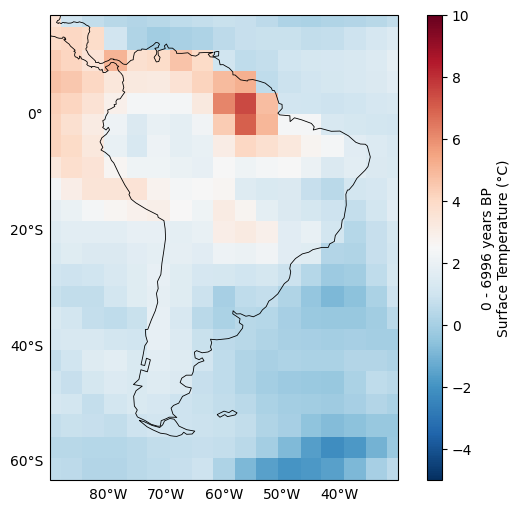

In [44]:
#----------------------south america only annual temperature DIFFERENCE (0 minus 6996)-----------------------------

# Create a figure for the difference in temperature over South America
fig, ax_sa = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

# Plot the difference over South America
img_sa = data_diff.plot.imshow(ax=ax_sa, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                               vmin=-5, vmax=10)
ax_sa.coastlines(linewidth=0.6)

# Set the extent to focus on South America
ax_sa.set_extent([-90, -30, -60, 15])  # Longitude range: -90 to -30, Latitude range: -60 to 15

# Add gridlines with specific label settings
gl = ax_sa.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels = False
gl.top_labels   = False

# Remove the automatic title
ax_sa.set_title('')

# Add a colorbar for the South America plot
cbar_sa = fig.colorbar(img_sa, ax=ax_sa, orientation='vertical', shrink=1.0, pad=0.05, aspect=30)
cbar_sa.set_label('0 - 6996 years BP' + '\n' + 'Surface Temperature (°C)', labelpad=6.5)

# Save the figure
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/diff_SA_annual_TEMP.png", bbox_inches='tight')

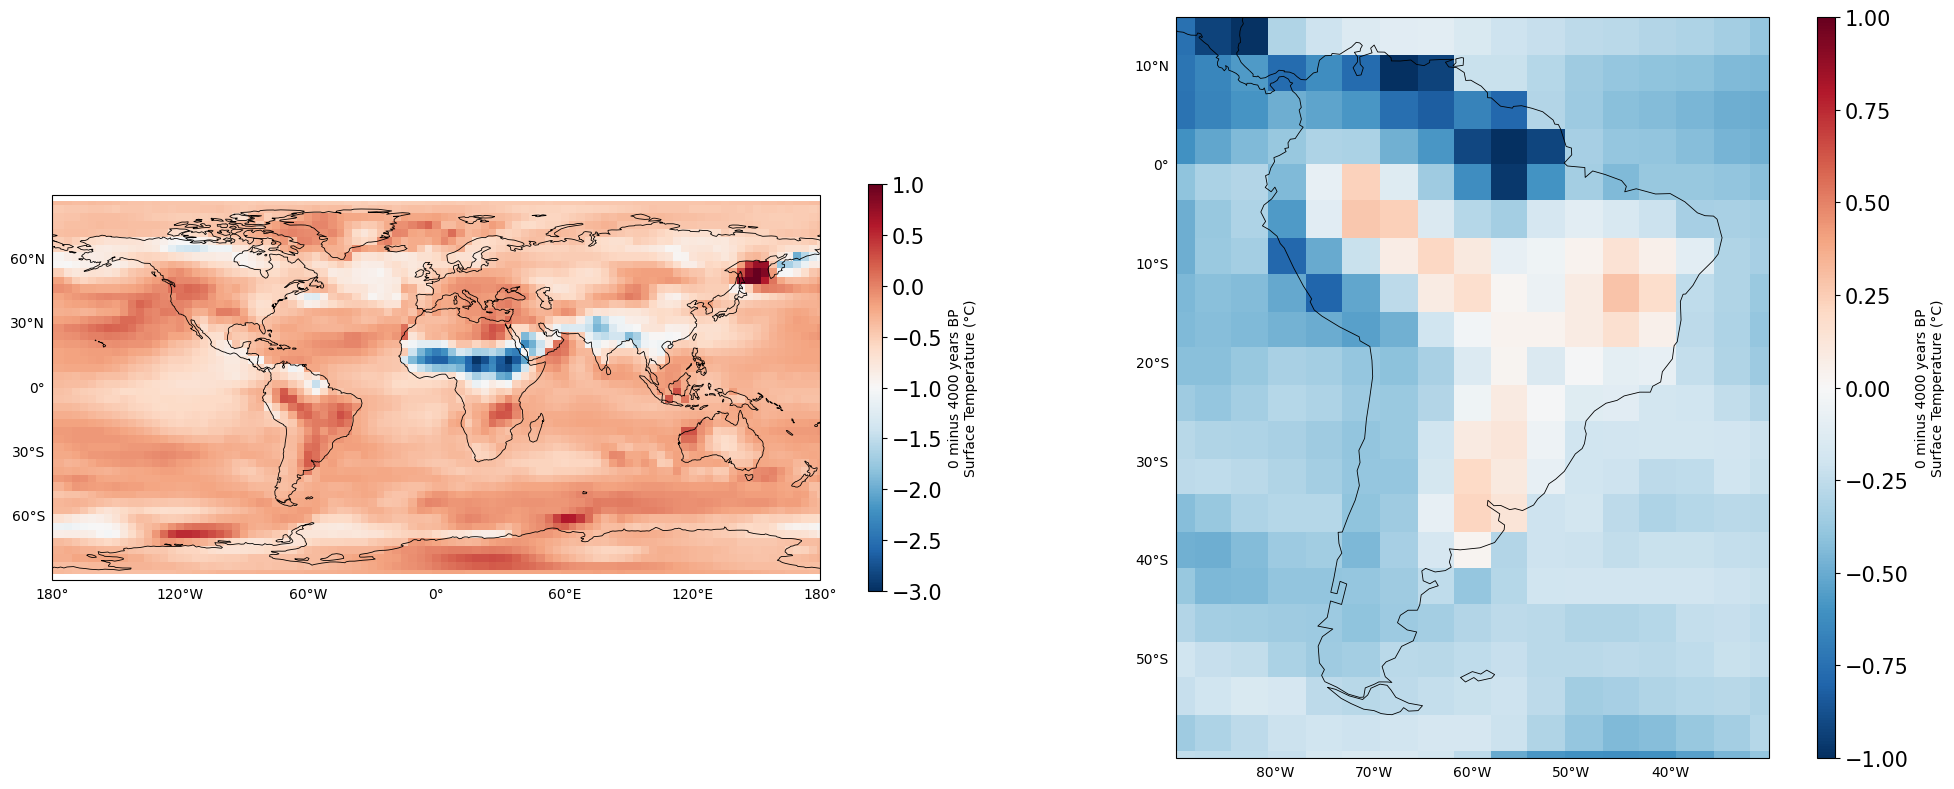

In [67]:
#--------------------global and south america annual temperature DIFFERENCE (0 minus 4000)-----------------------

# Define the start and end index ranges for the two time windows
start_index_0_100 = 0
end_index_0_100   = 100

start_index_4000_4100 = 4000
end_index_4000_4100   = 4100

# Slice data for the time window 0-100 years BP using .isel() for index selection
data_0_100 = data_ann.isel(time=slice(start_index_0_100, end_index_0_100 + 1))

# Slice data for the time window 4000-4100 years BP using .isel()
data_4000_4100 = data_ann.isel(time=slice(start_index_4000_4100, end_index_4000_4100 + 1))

# Compute the mean for the time window 0-100 years BP
mean_0_100 = data_0_100.mean(dim='time')

# Compute the mean for the time window 4000-4100 years BP
mean_4000_4100 = data_4000_4100.mean(dim='time')

# Compute the difference between the two means
mean_diff = mean_0_100 - mean_4000_4100

# Plotting the difference in annual surface temperature for Global and South America
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plotting for Global
ax_global = axes[0]
img_global = mean_diff.plot.imshow(ax=ax_global, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-3, vmax=1)
ax_global.coastlines(linewidth=0.6)
gl = ax_global.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels  = False
gl.top_labels = False
ax_global.set_global()

# Adjusting tick label sizes for global plot
ax_global.tick_params(axis='both', which='major', labelsize=17)

# Plotting for South America
ax_sa = axes[1]
img_sa = mean_diff.plot.imshow(ax=ax_sa, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-1, vmax=1)
ax_sa.coastlines(linewidth=0.6)
gl = ax_sa.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels  = False
gl.top_labels = False
ax_sa.set_extent([-90, -30, -60, 15], crs=ccrs.PlateCarree())  # Set South America extent

# Adjusting tick label sizes for South America plot
ax_sa.tick_params(axis='both', which='major', labelsize=17)

# Colorbars
cbar_global = fig.colorbar(img_global, ax=ax_global, orientation='vertical', shrink=0.55, pad=0.05, aspect=30)
cbar_global.set_label('0 minus 4000 years BP\nSurface Temperature (°C)')
cbar_global.ax.tick_params(labelsize=15)  # Adjust colorbar tick label size

cbar_sa = fig.colorbar(img_sa, ax=ax_sa, orientation='vertical', shrink=1.0, pad=0.05, aspect=40)
cbar_sa.set_label('0 minus 4000 years BP\nSurface Temperature (°C)')
cbar_sa.ax.tick_params(labelsize=15)  # Adjust colorbar tick label size

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/0-100_vs_4000-4100_annual_TEMP_diff_global_sa.png", bbox_inches='tight')

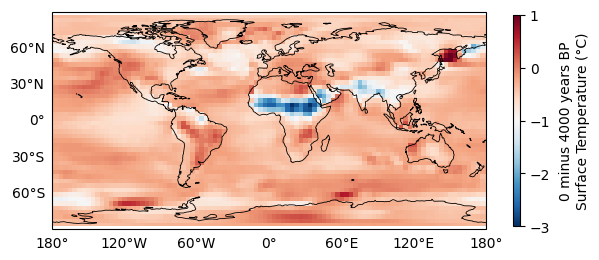

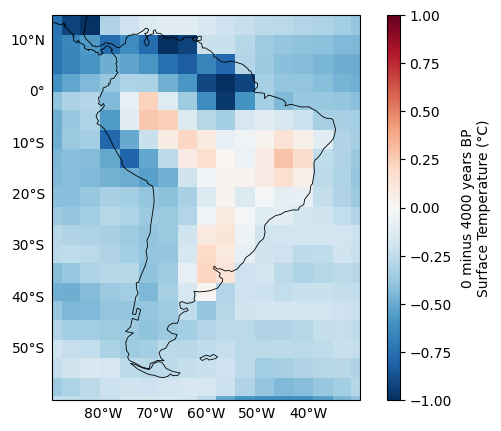

In [77]:
#-----------------------global and south america annual temperature DIFFERENCE (0 minus 4000)----------------------

# Define the start and end index ranges for the two time windows
start_index_0_100 = 0
end_index_0_100   = 100

start_index_4000_4100 = 4000
end_index_4000_4100   = 4100

# Slice data for the time window 0-100 years BP using .isel() for index selection
data_0_100 = data_ann.isel(time=slice(start_index_0_100, end_index_0_100 + 1))

# Slice data for the time window 4000-4100 years BP using .isel()
data_4000_4100 = data_ann.isel(time=slice(start_index_4000_4100, end_index_4000_4100 + 1))

# Compute the mean for the time window 0-100 years BP
mean_0_100 = data_0_100.mean(dim='time')

# Compute the mean for the time window 4000-4100 years BP
mean_4000_4100 = data_4000_4100.mean(dim='time')

# Compute the difference between the two means
mean_diff = mean_0_100 - mean_4000_4100

# ===================== PLOT 1: Global Plot ===================== #

fig_global, ax_global = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Plotting for Global
img_global = mean_diff.plot.imshow(ax=ax_global, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-3, vmax=1)
ax_global.coastlines(linewidth=0.6)
gl = ax_global.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels  = False
gl.top_labels = False
ax_global.set_global()

# Add colorbar for global plot
cbar_global = fig_global.colorbar(img_global, ax=ax_global, orientation='vertical', shrink=0.55, pad=0.05, aspect=30)
cbar_global.set_label('0 minus 4000 years BP\nSurface Temperature (°C)', labelpad=6.5)
#cbar_global.ax.tick_params(labelsize=15)  # Adjust colorbar tick label size

# Save global plot
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/0-100_vs_4000-4100_global_TEMP_diff.png", bbox_inches='tight')

# ===================== PLOT 2: South America Plot ===================== #

fig_sa, ax_sa = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Plotting for South America
img_sa = mean_diff.plot.imshow(ax=ax_sa, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', vmin=-1, vmax=1)
ax_sa.coastlines(linewidth=0.6)
gl = ax_sa.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels  = False
gl.top_labels = False
ax_sa.set_extent([-90, -30, -60, 15], crs=ccrs.PlateCarree())  # Set South America extent

# Add colorbar for South America plot
cbar_sa = fig_sa.colorbar(img_sa, ax=ax_sa, orientation='vertical', shrink=1.0, pad=0.05, aspect=30)
cbar_sa.set_label('0 minus 4000 years BP\nSurface Temperature (°C)', labelpad=6.5)
#cbar_sa.ax.tick_params(labelsize=15)  # Adjust colorbar tick label size

# Save South America plot
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/0-100_vs_4000-4100_SA_TEMP_diff.png", bbox_inches='tight')

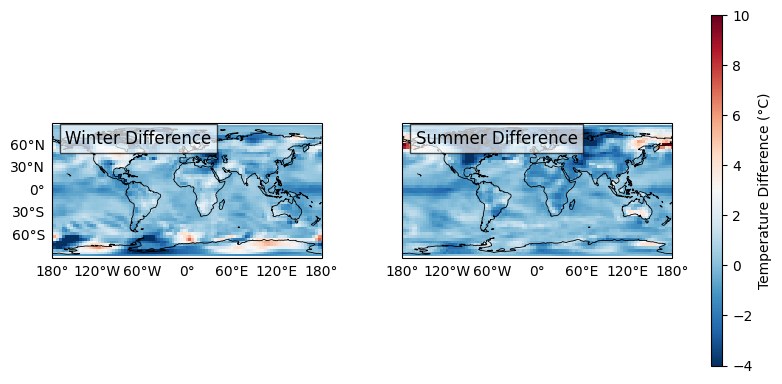

In [46]:
#-------------------------global seasonal temperature DIFFERENCE (0 to 6996)------------------------------------

# Indices for 0 and 6996 years BP
index_0_BP    = 0  # Start index
index_6996_BP = 6996  # End index for 6996 years BP

# Extract the data for 0 BP and 6996 BP
data_0_BP    = complete_data.isel(time=slice(index_0_BP, index_0_BP + 12))  # Select 12 months of data for 0 BP
data_6996_BP = complete_data.isel(time=slice(index_6996_BP, index_6996_BP + 12))  # Select 12 months of data for 6996 BP

austral_summer = [12,1,2]
austral_winter = [6,7,8]

# Select summer and winter for both time points using .sel or .where
summer_0_BP = data_0_BP.sel(time=data_0_BP['time.month'].isin(austral_summer)).mean(dim='time')
winter_0_BP = data_0_BP.sel(time=data_0_BP['time.month'].isin(austral_winter)).mean(dim='time')

summer_6996_BP = data_6996_BP.sel(time=data_6996_BP['time.month'].isin(austral_summer)).mean(dim='time')
winter_6996_BP = data_6996_BP.sel(time=data_6996_BP['time.month'].isin(austral_winter)).mean(dim='time')

# Calculate the difference between 0 BP and 6996 BP for both seasons
summer_diff = summer_0_BP - summer_6996_BP
winter_diff = winter_0_BP - winter_6996_BP

# Plot the difference for summer and winter
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 13), subplot_kw={'projection': ccrs.PlateCarree()})

# Adjust space between plots
fig.subplots_adjust(wspace=0.3)

# Plot summer difference
ax = axes[1]
im = summer_diff.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                             vmin=-4, vmax=10)
ax.coastlines(linewidth=0.6)
#ax.set_extent([-90, -30, -60, 15])  # Focus on South America
gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False

# Remove the automatic title
ax.set_title('')

# Add annotation for summer difference inside the plot
ax.text(0.05, 0.95, 'Summer Difference', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Plot winter difference
ax = axes[0]
im = winter_diff.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', add_colorbar=False, extend='both', 
                             vmin=-4, vmax=10)
ax.coastlines(linewidth=0.6)
#ax.set_extent([-90, -30, -60, 15])  # Focus on South America
gl = ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.0, linestyle='--')
gl.right_labels = False
gl.top_labels = False

# Remove the automatic title
ax.set_title('')

# Add annotation for winter difference inside the plot
ax.text(0.05, 0.95, 'Winter Difference', transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# Add colorbar with shrink below the summer plot
cbar = fig.colorbar(im, ax=axes, orientation='vertical', shrink=0.35, aspect=30, pad=0.05)
cbar.set_label('Temperature Difference (°C)')

# Save the combined figure without any external titles
#plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/0-6996_SA_seasonal_TEMP_diff.png", bbox_inches='tight')

In [47]:
#---------------------------------------TIME SERIES - ANNUAL MEAN TEMPERATURE----------------------------

# Reverse time (assuming integer indexing is allowed)
reversed_time_ann  = dates_ann[::-1]  # Assuming dates_ann is a list-like object

# Assign the reversed time coordinates to the 'time' dimension
reversed_xr_ann    = data_ann.assign_coords(time=reversed_time_ann)

# Ensure the changes are applied
data_ann["time"]   = reversed_xr_ann

def calculate_regional_means(ds, lon_target, lat_target, radius_deg,):
    """
    Calculate regional means around a specific longitude and latitude location
    with a given radius for a NetCDF dataset using xarray.
    """
    # Find indices of the nearest grid point to the target location
    
    if hasattr(ds, "longitude"):
        ds = ds.rename({"longitude":"lon", "latitude":"lat"})
        
    ds = ds.assign_coords({"lon": (((ds.lon + 180) % 360) - 180)})
    
    indices = extract_indices_around(ds, lat_target, lon_target, radius_deg)
    
    regional_mean = ds.isel(lat=indices[0], lon=indices[1]).mean(dim=("lon", "lat")).data
        
    return np.float64(regional_mean)

# coordinates of location are given along with 100 degree radius of the location area
location_ann = calculate_regional_means(ds=reversed_xr_ann, lon_target=-56, lat_target=-20, radius_deg=100)

# Convert NumPy array to xarray DataArray
location_ann_xr = xr.DataArray(location_ann, dims=['time'])

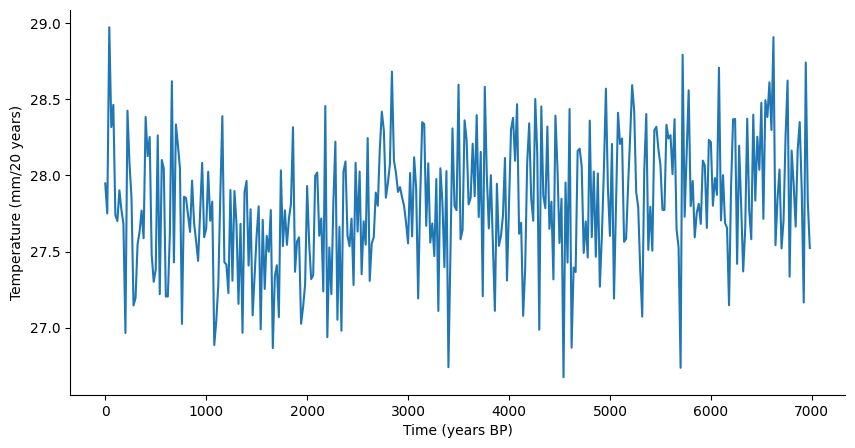

In [48]:
# Convert the data into a Pandas DataFrame
df_ann = pd.DataFrame(location_ann_xr, columns=['Value']) 
df_ann['Year_BP'] = np.arange(6996, -1, -1)

# Group the data into means of every 20 years
grouped_df_ann = df_ann.groupby(df_ann.index // 20).mean()
grouped_df_ann['Year_BP'] = grouped_df_ann['Year_BP'] // 20 * 20

# Plot the data
fig,ax = plt.subplots(figsize=(10, 5))    
fig.patch.set_visible(False)              # Hide the figure's outer border

# Adjust the spines to keep the axes visible but remove the figure's borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(grouped_df_ann['Year_BP'], grouped_df_ann['Value'])
ax.set_xlabel('Time (years BP)')
ax.set_ylabel('Temperature (mm/20 years)')
#plt.title('20-Year Mean Temperature of Dona Benedita Cave')
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/Global Annual Mean TEMP of Dona Benedita Cave Every 20 Years.png")

In [50]:
#---------------------------------------TIME SERIES - SEASONAL MEAN TEMPERATURE----------------------------------

# Reverse coordinates (assuming integer indexing is allowed)
reversed_time  = complete_dates[::-1]  # Assuming dates_ann is a list-like object

# Assign the reversed time coordinates to the 'time' dimension
reversed_xr    = complete_data.assign_coords(time=reversed_time)

# Ensure the changes are applied
data["time"]   = reversed_xr

def calculate_regional_means(ds, lon_target, lat_target, radius_deg,):
    """
    Calculate regional means around a specific longitude and latitude location
    with a given radius for a NetCDF dataset using xarray.
    """
    # Find indices of the nearest grid point to the target location
    
    if hasattr(ds, "longitude"):
        ds = ds.rename({"longitude":"lon", "latitude":"lat"})
        
    ds = ds.assign_coords({"lon": (((ds.lon + 180) % 360) - 180)})
    
    indices = extract_indices_around(ds, lat_target, lon_target, radius_deg)
    
    regional_mean = ds.isel(lat=indices[0], lon=indices[1]).mean(dim=("lon", "lat")).data
        
    return np.float64(regional_mean)

# coordinates of location are given along with 100 degree radius of the location area
location = calculate_regional_means(ds=reversed_xr, lon_target=-56, lat_target=-20, radius_deg=100)

# Convert NumPy array to xarray DataArray
location_xr = xr.DataArray(location, dims=['time'])

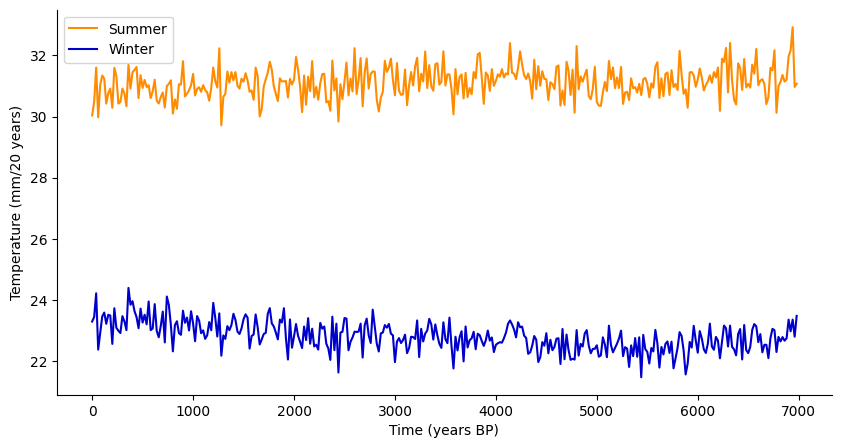

In [51]:
# Convert the data into a Pandas DataFrame
df = pd.DataFrame(location_xr, columns=['Value']) 
df['Months'] = np.arange(83956, -1, -1)

# Create a DataFrame from your data and the dates
df = pd.DataFrame({"Value": location_xr, "Date": complete_dates})

# Extract the year and month directly from the 'Date' column
df['Year_BP'] = df['Date'].apply(lambda x: x.year)
df['Month']   = df['Date'].apply(lambda x: x.month)

# Define austral summer and winter months
austral_summer = [12, 1, 2]
austral_winter = [6, 7, 8]

# Define a function to label the seasons
def label_season(month):
    if month in austral_summer:
        return 'Summer'
    elif month in austral_winter:
        return 'Winter'
    else:
        return 'Other'

# Apply the season labeling
df['Season']   = df['Month'].apply(label_season)

# Filter out only summer and winter data
df_season      = df[df['Season'].isin(['Summer', 'Winter'])]

# Group by year and season, then calculate the mean
seasonal_means = df_season.groupby(['Year_BP', 'Season'])['Value'].mean().unstack()

# Create 20-year bins
seasonal_means['20yr_Bin'] = (seasonal_means.index // 20) * 20

# Group by the 20-year bins and calculate the mean for each season
seasonal_means_20yr        = seasonal_means.groupby('20yr_Bin').mean()

# Plot the data for both Summer and Winter
fig,ax = plt.subplots(figsize=(10, 5))    
fig.patch.set_visible(False)              # Hide the figure's outer border

# Adjust the spines to keep the axes visible but remove the figure's borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(seasonal_means_20yr.index, seasonal_means_20yr['Summer'], label='Summer', color='darkorange')
ax.plot(seasonal_means_20yr.index, seasonal_means_20yr['Winter'], label='Winter', color='mediumblue')
ax.set_xlabel('Time (years BP)')
ax.set_ylabel('Temperature (mm/20 years)')
#plt.title('20-Year Mean Seasonal Temperature of Dona Benedita Cave')
plt.legend()
plt.savefig("/home/rvejayan/ECHAM5-wiso_7k_temp/Seasonal Mean TEMP of Dona Benedita Cave Every 20 Years.png")